# An introduction to numerical uncertainty propogation with Monte Carlo methods and bootstrap sampling

1. [Monte Carlo methods](#Monte-Carlo-methods)
  - [A basic Monte Carlo example using normally distributed data](#A-basic-Monte-Carlo-example-using-normally-distributed-data)
2. [Bootstrap sampling](#Bootstrap-sampling)
  - [Bootstrap sampling implementation](#Bootstrap-sampling-implementation)
  - [Visualizing bootstrap sampling](#Visualizing-bootstrap-sampling)
3. [Weighted bootstrap sampling](#Weighted-bootstrap-sampling)
4. [Monte Carlo with bootstrap sampling](#Monte-Carlo-with-bootstrap-sampling)


## Monte Carlo methods
[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) are statistical techniques that use repeated random sampling to obtain numerical results.  A common application is for uncertainty propagation parametric models (e.g. a normal distribution defined by a mean and standard deviation) of different parameter values.

For example, suppose we want to add or multiplying two parameters (x1, x2) that have are estimated to be normally distributed with mean of 4 and 5, and standard deviation of 1 and 2 respectively.  A convenient notation to describe these two normally distributed parameters is:
- x1: N~(4,1)
- x2: N~(5,2)

We can use monte carlo methods to estimate the product of x1 and x2 by sampling from their distributions:
y = N~(4,1) * N(5,2)

A more simplified approach to account for uncertainty might be to generate high, medium and low estimates based on the extreme and mean values that are known for each parameter.  A potential benefit of using monte carlo methods to estimate uncertainty compared to 'medium', 'high' and 'low' estimates is the narrow uncertainty bounds (e.g. based on 2 standard devations) provided by monte carlo estimates.  Tighter uncertainty bounds result from reduced sampling of unlikely events (i.e. the tails of the probability distribution) when monte carlo methods are used. Based on probability theory ([regression to the mean](https://en.wikipedia.org/wiki/Regression_toward_the_mean)), the probability that the result is the combination of extreme values is low compared to other outcomes.  This 'benefit' of tighter uncertainty bounds presumes that uncertainty bounds are fairly well understood which may not the case due to a variety of unknowns.  

### A basic Monte Carlo example using normally distributed data

In [1]:
import numpy as np  # 1.18.1
import seaborn as sns  # 0.10
from matplotlib import pyplot as plt  # 3.1.3
%matplotlib inline

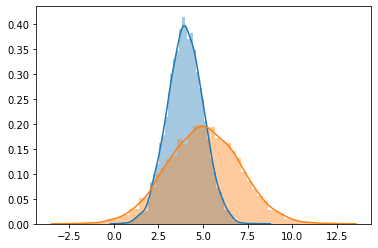

In [2]:
n_samples = 10000
x1_mean = 4
x1_SD = 1
x2_mean = 5
x2_SD = 2
x1 = np.random.normal(x1_mean, x1_SD, n_samples)
x2 = np.random.normal(x2_mean, x2_SD, n_samples)
sns.distplot(x1)
sns.distplot(x2)

Deterministic result = 20


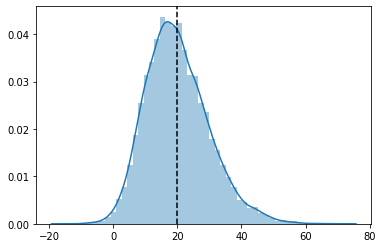

In [3]:
y = x1 * x2
sns.distplot(y)
print(f"Deterministic result = {x1_mean * x2_mean}")
plt.axvline(x1_mean * x2_mean, color='black', linestyle='--')

It might seem odd that some negative values are returned from the multiplication of 4 * 5. This is because a normal distribution is used to represent the parameter distribution. The normal distribution is defined along the range $-\infty$ to $+\infty$.  If negative values are not possible, other distributions that do not have negative values can be used like the lognormal distribution.

Deterministic result = 20


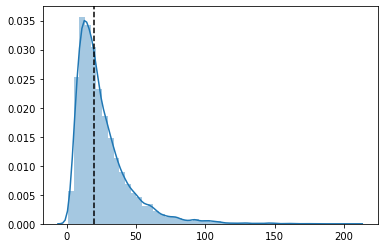

In [4]:
x1 = np.random.lognormal(np.log(x1_mean), np.log(x1_SD), n_samples)
x2 = np.random.lognormal(np.log(x2_mean), np.log(x2_SD), n_samples)
y = x1 * x2
sns.distplot(y)
print(f"Deterministic result = {x1_mean * x2_mean}")
plt.axvline(x1_mean * x2_mean, color='black', linestyle='--')

## Bootstrap sampling

Sometimes the underlying distribution of a parameter value may be unknown.  Instead we might have a handfull of parameter estimates from different sources that we may want to reconcile with our uncertainty assessment.  One approach might be to take the mean of these values and make an assumption about the parameter distribution.  With a large sample size, sample statistics (mean, standard deviation) can be estimated from using each of the individual estimates.  With smaller sample sizes, bootstrap sampling with replacement is a technique that can be used to estimate the underlying distribution from a set of point estimates.  

For example, say we have five estimates of x1 instead of an estimate for x1 of N~(4,1):
- x1_1 = 3
- x1_2 = 4.5
- x1_3 = 7
- x1_4 = 3.5
- x1_5 = 5

In this example each of these estimates is a point value with no descriptive statistics to indicate uncertainty.  Bootstrap sampling with replacement works by sampling a number of values (e.g. 3) from the set of x1_1 to x1_5 using replacement (each time a value is sampled from the set it is not removed and so can be resampled again on the next draw) and taking the average of the sampled values.  Bootstraping undertakes this sampling procedure repeatedly to build a distribution to represent the entire sample

Now let's implement a method for bootstrap sampling and apply it to this set of estimates for x1.

### Bootstrap sampling implementation

In [5]:
def bootstrap_sample(x, n_samples, smoothed=True, replace=True, p=None):
    """
    Parameters
    --------------
    x : 1-D array-like.
        Sample to compute bootstrap statistics from.
    n_samples : int
        Number of bootstrap samples to return.
    smoothed : bool
        Whether smoothed sampling is used.
    replace : bool
        Whether sampling with replacement is used.
    p : 1-D array-like
        Probability for each value of x for weighted sampling.
        
    Notes
    --------------
    References:  https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Smoothed_bootstrap
    """
    size = (n_samples, len(x))
    bootstrap_samples = np.random.choice(x, size, replace, p)
    bootstrap_result = np.mean(bootstrap_samples, axis=1)
    
    if smoothed:
        noise = gaussian_noise(x, n_samples)
        return bootstrap_result + noise

    return bootstrap_result

def gaussian_noise(x, n_samples)->np.ndarray:
    """Create guassian noise of len(n_samples).
    
    Parameters
    ------------
    x : ndarray
    n_samples : int
    """
    # arbitrarily set sigma (see Reference)
    sigma = 1/np.sqrt(len(x))
    sigma_squared = np.power(sigma, 2)
    noise = np.random.normal(0, sigma_squared, n_samples)
    return noise

### Visualizing bootstrap sampling

histogram of raw data


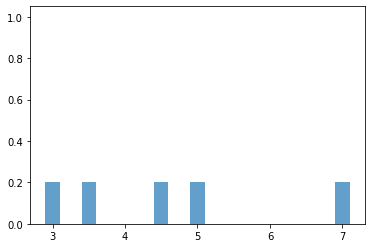

In [6]:
x1 = [3,4.5,7,3.5,5]
p = [1/len(x1)]*len(x1)
sns.distplot(x1, bins=20, kde=False, color='white')
plt.bar(x1, p, width=0.2, alpha=0.7)
print("histogram of raw data")

bootstrapped sample


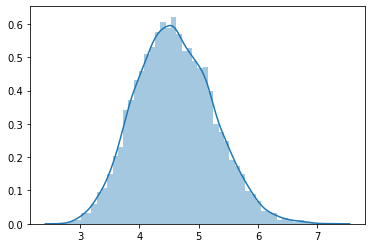

In [7]:
x1_bootstrap = bootstrap_sample(x1, n_samples)
sns.distplot(x1_bootstrap)
print("bootstrapped sample")

In [8]:
print("Statistics statistics of x1")
print("mean: {}".format(np.mean(x1)))
print("std: {}".format(np.std(x1)))
print("-----------")
print("Bootstrap statistics")
print("mean: {}".format(np.mean(x1_bootstrap)))
print("std: {}".format(np.std(x1_bootstrap)))

Statistics statistics of x1
mean: 4.6
std: 1.3928388277184118
-----------
Bootstrap statistics
mean: 4.595724556315693
std: 0.6497809015917908


## Monte Carlo with bootstrap sampling

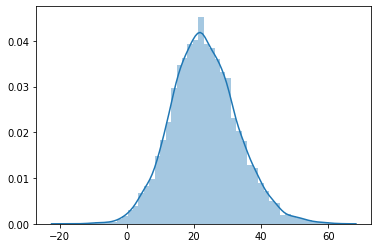

In [9]:
y = x1_bootstrap * np.random.normal(x2_mean, x2_SD, n_samples)
sns.distplot(y)

## Weighted bootstrap sampling

The weighted bootsrap method we have defined above also given us the opportunity to apply a weighting factor to each of the individual estimates.  This can be useful if there is some evidence to suggest that certain parameter estimates are more likely or valid than others (e.g. measurement procedures follow standard practices).  We can use this information to influence the likelihood that specific estimates will be sampled.

histogram of weighted data.


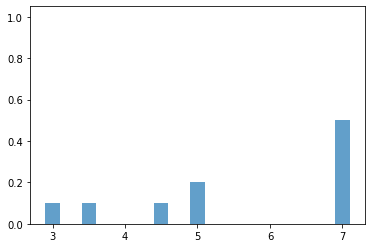

In [10]:
x1 = [3,4.5,7,3.5,5]
p = [0.1,0.1,0.5,0.1,0.20]
sns.distplot(x1, bins=20, kde=False, color='white');
plt.bar(x1,p, width=0.2, alpha=0.7);
print("histogram of weighted data.")

sample statistics from bootstrap sampling with replacement
mean: 5.596304277196057
std: 0.7162682928679842


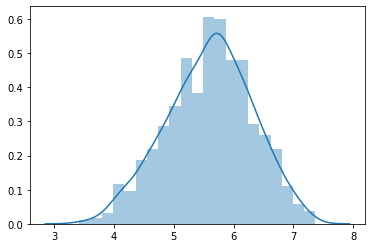

In [11]:
x1_bootstrap = bootstrap_sample(x1, n_samples=1000, p=[0.1,0.1,0.5,0.1,0.2])
print("sample statistics from bootstrap sampling with replacement")
print("mean: {}".format(np.mean(x1_bootstrap)))
print("std: {}".format(np.std(x1_bootstrap)))
sns.distplot(x1_bootstrap)

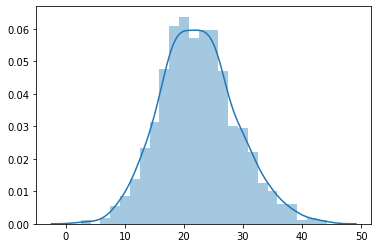

In [12]:
samples = 1000
y = np.random.normal(4,1, samples)*x1_bootstrap
sns.distplot(y)